# COMS4062A - Probabilistic Graphical Models
# Assignment
# Heart disease/failure prediction using Bayesian Networks
# Luca von Mayer 2427051@students.wits.ac.za

# Section 3: Parameter Estimation and Inference

imports

In [243]:
import os
import time
import warnings
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from pgmpy.estimators import *
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination, CausalInference, BeliefPropagation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, accuracy_score
warnings.simplefilter('ignore')

# Train/Test split

In [244]:
data = pd.read_csv("heartProcessed.csv")

X = (data.iloc[:, :-1])
y = (data.iloc[:, -1])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

print(train_data.shape)
print(test_data.shape)


(734, 12)
(184, 12)


Setting up the save file

In [245]:
result_file = "paraminferResults.csv"

# Overwrite the file with headers
with open(result_file, 'w', newline='') as file:
    file.write("PETechnique,Inference,Accuracy,F1,RunTime\n")

# Initialize a set to store unique rows
unique_rows = set()

# Scoring Metrics

In [246]:
def score(test_data, predict_data):
    if isinstance(predict_data[0], (float, int)):
        # predict_data contains probabilities
        binary_predictions = [int(p > 0.5) for p in predict_data]
        accuracy = accuracy_score(test_data['HeartDisease'], binary_predictions)
        f1 = f1_score(test_data['HeartDisease'], binary_predictions)
        conf_matrix = confusion_matrix(test_data['HeartDisease'], binary_predictions)
    else:
        # predict_data contains binary or categorical values
        accuracy = accuracy_score(test_data['HeartDisease'], predict_data)
        f1 = f1_score(test_data['HeartDisease'], predict_data)
        conf_matrix = confusion_matrix(test_data['HeartDisease'], predict_data)

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("Confusion Matrix:")
    print(conf_matrix)
    return accuracy, f1


Modellling

In [247]:
scoring_method = K2Score(data=data)
est = HillClimbSearch(data=data)
dag = est.estimate(
scoring_method=scoring_method, max_indegree = 3)

dag.add_nodes_from(data.columns)
model = BayesianNetwork(dag)

  0%|          | 0/1000000 [00:00<?, ?it/s]

# Parameter estimation and Inference

In [248]:
def run_experiment(PETechnique, Inference, prior_type=None, equivalent_sample_size=100):
    start_time = time.time() # Record the start time
    param_est = None
    if PETechnique == "MaximumLikelihoodEstimator":
        param_est = MaximumLikelihoodEstimator(model, data)
    elif PETechnique.startswith("BayesianEstimator"):
        param_est = BayesianEstimator(model, data)
    if param_est:
        if prior_type:
            model.add_cpds(*param_est.get_parameters(prior_type=prior_type, equivalent_sample_size=equivalent_sample_size))
        else:
            model.add_cpds(*param_est.get_parameters())
    model.check_model()
    infer = None
    if Inference == "VariableElimination":
        infer = VariableElimination(model)
    elif Inference == "BeliefPropagation":
        infer = BeliefPropagation(model)
    elif Inference == "CausalInference":
        infer = CausalInference(model)
    if infer:
        predict_data = []
        for index, row in test_data.iterrows():
            evid = {var: row[var] for var in model.nodes() if var != 'HeartDisease'}
            if Inference == "CausalInference":
                prediction = infer.query(variables=['HeartDisease'], evidence=evid)
                predict_data.append(prediction.values[1])
            else:
                prediction = infer.map_query(variables=['HeartDisease'], evidence=evid, show_progress=False)
                predict_data.append(prediction['HeartDisease'])
                
        accuracy, f1 = score(test_data, predict_data)
        
        end_time = time.time() # Record the end time
        run_time = end_time - start_time # Calculate the runtime
        print(f"Run time: {run_time:.4f} seconds") # Print the runtime
            
        new_row = f"{PETechnique},{Inference},{accuracy},{f1}, {run_time:.4f}"
        if new_row not in unique_rows:
            with open(result_file, 'a') as file:
                file.write(new_row + "\n")
            unique_rows.add(new_row)
 


In [249]:
run_experiment("MaximumLikelihoodEstimator", "VariableElimination")

Accuracy: 0.8967391304347826
F1 Score: 0.9099526066350712
Confusion Matrix:
[[69  8]
 [11 96]]
Run time: 0.8804 seconds


In [250]:
run_experiment("BayesianEstimatorBDeu", "VariableElimination", "BDeu")

Accuracy: 0.8967391304347826
F1 Score: 0.9107981220657277
Confusion Matrix:
[[68  9]
 [10 97]]
Run time: 0.8922 seconds


In [251]:
run_experiment("BayesianEstimatorK2", "VariableElimination", "K2")

Accuracy: 0.8858695652173914
F1 Score: 0.9004739336492891
Confusion Matrix:
[[68  9]
 [12 95]]
Run time: 0.8911 seconds


In [252]:
run_experiment("MaximumLikelihoodEstimator", "BeliefPropagation")

Accuracy: 0.8967391304347826
F1 Score: 0.9099526066350712
Confusion Matrix:
[[69  8]
 [11 96]]
Run time: 2.4443 seconds


In [253]:
run_experiment("BayesianEstimatorBDeu", "BeliefPropagation", "BDeu")

Accuracy: 0.8967391304347826
F1 Score: 0.9107981220657277
Confusion Matrix:
[[68  9]
 [10 97]]
Run time: 2.2659 seconds


In [254]:
run_experiment("BayesianEstimatorK2", "BeliefPropagation", "K2")

Accuracy: 0.8858695652173914
F1 Score: 0.9004739336492891
Confusion Matrix:
[[68  9]
 [12 95]]
Run time: 2.2511 seconds


In [255]:
run_experiment("MaximumLikelihoodEstimator", "CausalInference")

Accuracy: 0.8967391304347826
F1 Score: 0.9099526066350712
Confusion Matrix:
[[69  8]
 [11 96]]
Run time: 0.3739 seconds


In [256]:
run_experiment("BayesianEstimatorBDeu", "CausalInference", "BDeu")

Accuracy: 0.8967391304347826
F1 Score: 0.9107981220657277
Confusion Matrix:
[[68  9]
 [10 97]]
Run time: 0.4305 seconds


In [257]:
run_experiment("BayesianEstimatorK2", "CausalInference", "K2")

Accuracy: 0.8858695652173914
F1 Score: 0.9004739336492891
Confusion Matrix:
[[68  9]
 [12 95]]
Run time: 0.3709 seconds


# Plotting Results

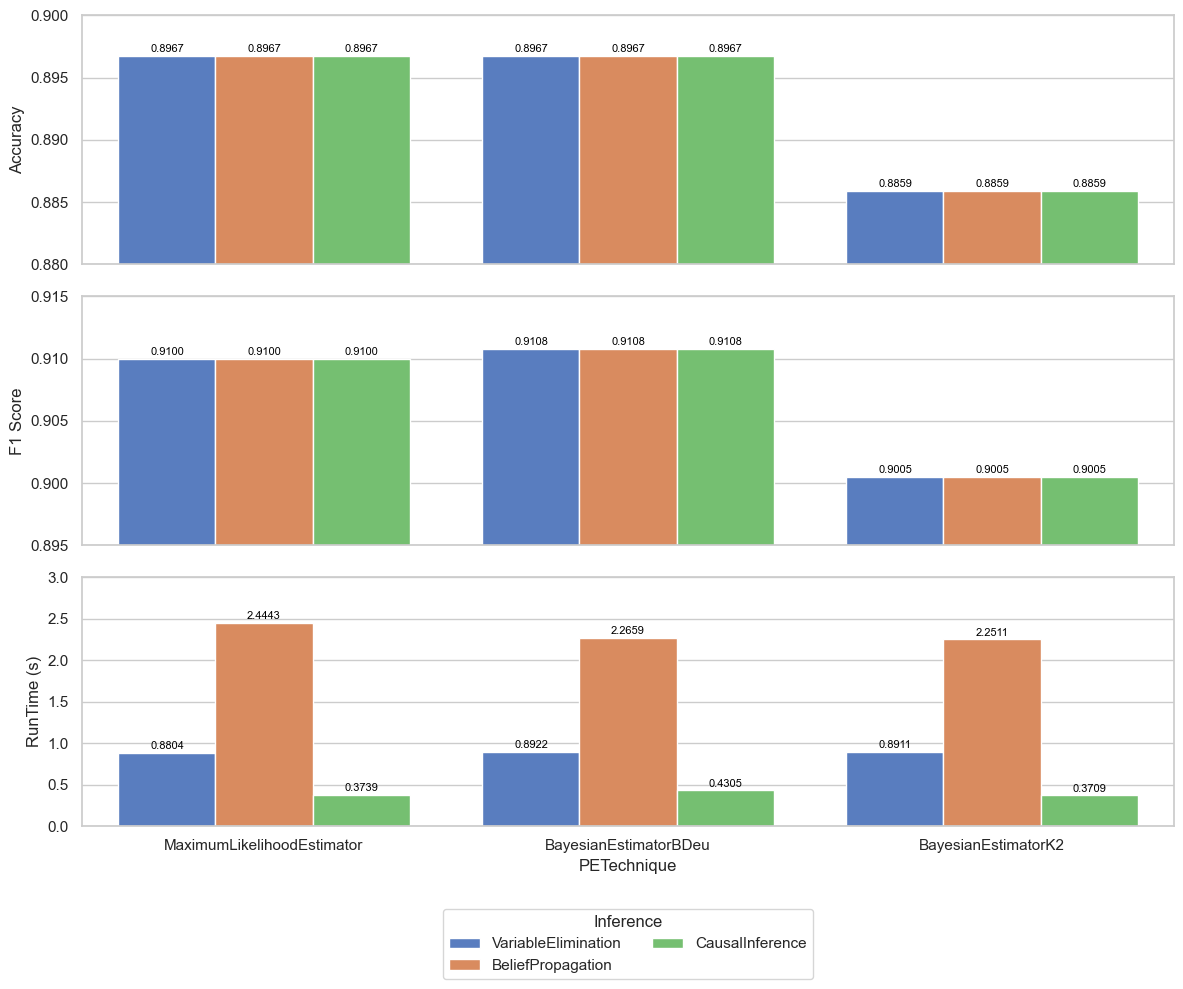

In [259]:
dataPlot = pd.read_csv("paraminferResults.csv")

# Set style
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# Plot Accuracy
ax1 = sns.barplot(data=dataPlot, x="PETechnique", y="Accuracy", hue="Inference", palette="muted", ax=axes[0])
# Add labels to the bars
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
ax1.set_xlabel("")
ax1.set_ylabel("Accuracy")
ax1.set_xticklabels([])
ax1.legend().remove()
# Set y-axis limits
ax1.set_ylim(0.88, 0.90)

# Plot F1 Score
ax2 = sns.barplot(data=dataPlot, x="PETechnique", y="F1", hue="Inference", palette="muted", ax=axes[1])
# Add labels to the bars (sideways)
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
ax2.set_xlabel("")
ax2.set_ylabel("F1 Score")
ax2.set_xticklabels([])
ax2.legend().remove()
# Set y-axis limits
ax2.set_ylim(0.895, 0.915)

# Plot Run Time
ax3 = sns.barplot(data=dataPlot, x="PETechnique", y="RunTime", hue="Inference", palette="muted", ax=axes[2])
# Add labels to the bars (sideways)
for p in ax3.patches:
    ax3.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
ax3.set_xlabel("PETechnique")
ax3.set_ylabel("RunTime (s)")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)  # Rotate x-axis labels
# Set y-axis limits
ax3.set_ylim(0, 3)


# Adjust layout
plt.tight_layout()

# Move the legend to the bottom
plt.legend(title="Inference", bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=2)

# Show plot
plt.show()

